<a href="https://colab.research.google.com/github/jgssung/IoT_Lab2/blob/main/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using Device: cpu
>>> Fashion-MNIST 로드 및 Non-IID 분할...


100%|██████████| 26.4M/26.4M [00:01<00:00, 15.9MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 274kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.06MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 11.3MB/s]



[Simulation] Code 3 Logic + Loss Tracking
Round|Prox Acc | Avg Acc |Prox Loss | Avg Loss 
  1  | 18.26  %| 13.95  %|  2.2115  |  2.2211  
  2  | 41.52  %| 26.58  %|  2.0040  |  1.9830  
  3  | 43.17  %| 36.19  %|  1.8860  |  2.0653  
  4  | 43.65  %| 35.09  %|  1.7195  |  1.6979  
  5  | 48.05  %| 37.87  %|  1.5991  |  1.7490  
  6  | 50.25  %| 32.03  %|  1.5362  |  2.1304  
  7  | 48.97  %| 43.66  %|  1.5038  |  1.7550  
  8  | 40.89  %| 37.20  %|  1.7007  |  1.7793  
  9  | 50.70  %| 44.78  %|  1.3512  |  1.3086  
 10  | 54.92  %| 43.96  %|  1.3262  |  1.7215  
 11  | 59.78  %| 49.60  %|  1.2008  |  1.4637  
 12  | 50.62  %| 51.02  %|  1.2416  |  1.2764  
 13  | 48.70  %| 53.82  %|  1.2712  |  1.4386  
 14  | 55.97  %| 57.18  %|  1.1857  |  1.2774  
 15  | 62.77  %| 59.62  %|  1.1494  |  1.5656  
 16  | 60.74  %| 59.75  %|  1.1569  |  1.2011  
 17  | 56.91  %| 56.76  %|  1.1999  |  1.5343  
 18  | 61.17  %| 59.07  %|  1.0696  |  1.2071  
 19  | 64.85  %| 55.83  %|  1.0125  |  1.3875

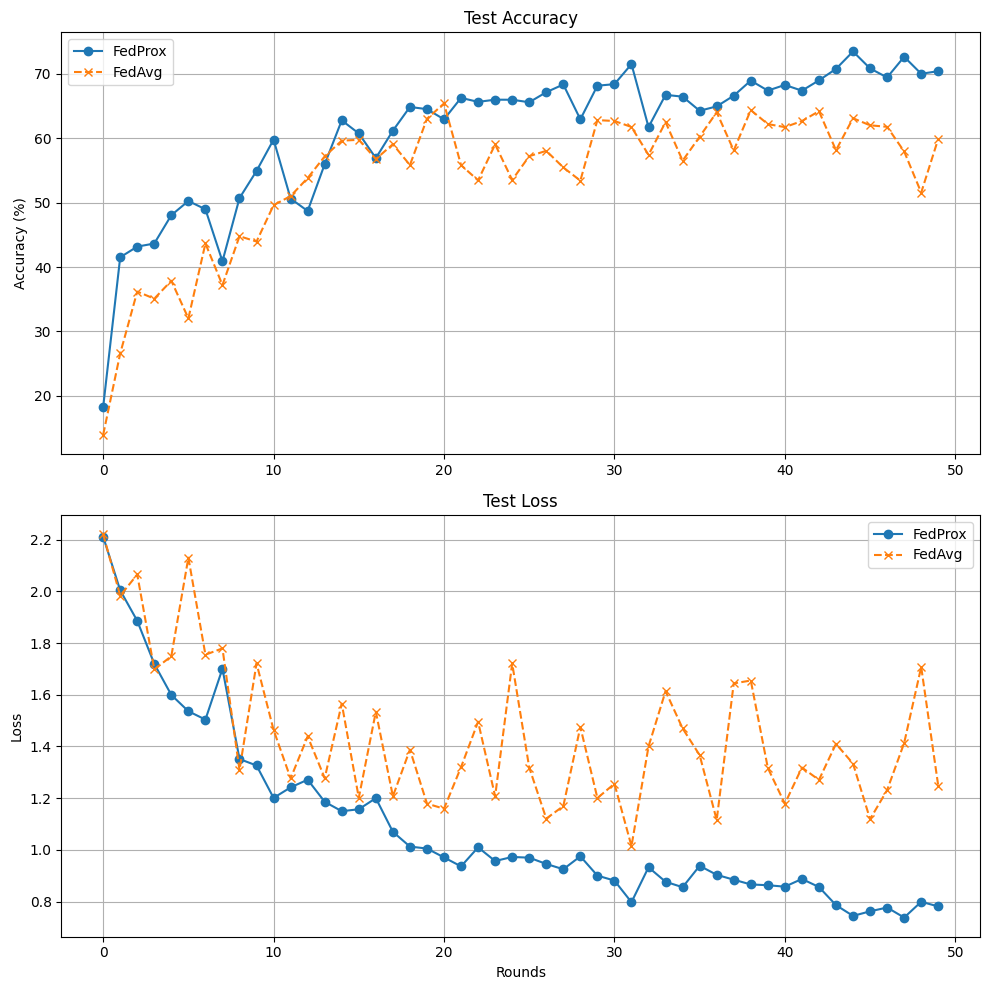

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import copy
import random
import matplotlib.pyplot as plt

# ==============================================================================
# [설정] Code 3 기반 + Loss 출력 추가
# ==============================================================================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {DEVICE}")

NUM_CLIENTS = 20
NUM_SELECTED = 10
NUM_ROUNDS = 50
BATCH_SIZE = 10
LR = 0.1
MU = 1.0

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

seed_everything(42)

# ==============================================================================
# 1. Dataset
# ==============================================================================
def get_fashion_mnist_noniid():
    print(">>> Fashion-MNIST 로드 및 Non-IID 분할...")
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    train_ds = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
    test_ds = datasets.FashionMNIST('./data', train=False, download=True, transform=transform)

    data_by_class = {i: [] for i in range(10)}
    for idx, target in enumerate(train_ds.targets):
        data_by_class[target.item()].append(idx)

    shards = []
    for cls in range(10):
        indices = data_by_class[cls]
        shard_len = len(indices) // 4
        for i in range(4):
            shards.append(indices[i*shard_len : (i+1)*shard_len])

    random_state = np.random.RandomState(42)
    random_state.shuffle(shards)

    client_indices = []
    for i in range(NUM_CLIENTS):
        client_indices.append(shards[2*i] + shards[2*i+1])

    return train_ds, test_ds, client_indices

# ==============================================================================
# 2. Model
# ==============================================================================
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 100)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# ==============================================================================
# 3. Local Training
# ==============================================================================
class LocalUpdate:
    def __init__(self, dataset, indices, device, client_id):
        self.loader = DataLoader(Subset(dataset, indices), batch_size=BATCH_SIZE, shuffle=True)
        self.device = device
        self.client_id = client_id
        self.criterion = nn.CrossEntropyLoss()

    def train(self, global_model, mu, is_prox):
        model = copy.deepcopy(global_model).to(self.device)
        model.train()
        optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.5)

        global_params = [p.clone().detach() for p in global_model.parameters()]

        if self.client_id % 3 == 0:
            epochs = 1
        else:
            epochs = 5

        for _ in range(epochs):
            for data, target in self.loader:
                data, target = data.to(self.device), target.to(self.device)
                optimizer.zero_grad()
                output = model(data)
                loss = self.criterion(output, target)

                if is_prox and mu > 0:
                    prox_term = 0.0
                    for w, w_t in zip(model.parameters(), global_params):
                        prox_term += (w - w_t.to(self.device)).norm(2)**2
                    loss += (mu / 2) * prox_term

                loss.backward()
                optimizer.step()

        return model.state_dict(), len(self.loader.dataset)

# ==============================================================================
# 4. Server Logic (Loss 추가됨)
# ==============================================================================
def average_weights(w_list, counts):
    w_avg = copy.deepcopy(w_list[0])
    total_count = sum(counts)
    for k in w_avg.keys():
        w_avg[k] = w_avg[k] * counts[0]
        for i in range(1, len(w_list)):
            w_avg[k] += w_list[i][k] * counts[i]
        w_avg[k] = w_avg[k] / total_count
    return w_avg

def evaluate(model, test_loader, device):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    correct = 0; total = 0
    test_loss = 0.0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            test_loss += loss.item() # Loss 누적

            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    accuracy = 100 * correct / total
    avg_loss = test_loss / len(test_loader) # 평균 Loss 계산
    return accuracy, avg_loss

# ==============================================================================
# 5. Experiment
# ==============================================================================
def run_experiment():
    train_ds, test_ds, user_groups = get_fashion_mnist_noniid()
    test_loader = DataLoader(test_ds, batch_size=100, shuffle=False)

    model_prox = SimpleNN().to(DEVICE)
    model_avg = SimpleNN().to(DEVICE)
    model_avg.load_state_dict(model_prox.state_dict())

    hist_acc_prox, hist_loss_prox = [], []
    hist_acc_avg, hist_loss_avg = [], []

    print(f"\n[Simulation] Code 3 Logic + Loss Tracking")
    print(f"{'Round':^5}|{'Prox Acc':^9}|{'Avg Acc':^9}|{'Prox Loss':^10}|{'Avg Loss':^10}")
    print("="*55)

    for round_idx in range(NUM_ROUNDS):
        idxs_users = np.random.choice(range(NUM_CLIENTS), NUM_SELECTED, replace=False)

        # FedProx
        w_prox, s_prox = [], []
        for idx in idxs_users:
            local = LocalUpdate(train_ds, user_groups[idx], DEVICE, client_id=idx)
            w, s = local.train(model_prox, MU, True)
            w_prox.append(w); s_prox.append(s)
        model_prox.load_state_dict(average_weights(w_prox, s_prox))

        # FedAvg
        w_avg, s_avg = [], []
        for idx in idxs_users:
            local = LocalUpdate(train_ds, user_groups[idx], DEVICE, client_id=idx)
            w, s = local.train(model_avg, 0.0, False)
            w_avg.append(w); s_avg.append(s)
        model_avg.load_state_dict(average_weights(w_avg, s_avg))

        # 평가 (Acc & Loss)
        acc_prox, loss_prox = evaluate(model_prox, test_loader, DEVICE)
        acc_avg, loss_avg = evaluate(model_avg, test_loader, DEVICE)

        hist_acc_prox.append(acc_prox); hist_loss_prox.append(loss_prox)
        hist_acc_avg.append(acc_avg); hist_loss_avg.append(loss_avg)

        print(f"{round_idx+1:^5}|{acc_prox:^8.2f}%|{acc_avg:^8.2f}%|{loss_prox:^10.4f}|{loss_avg:^10.4f}")

    # 그래프 2개 그리기
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

    ax1.plot(hist_acc_prox, 'o-', label='FedProx')
    ax1.plot(hist_acc_avg, 'x--', label='FedAvg')
    ax1.set_title("Test Accuracy")
    ax1.set_ylabel("Accuracy (%)")
    ax1.legend(); ax1.grid()

    ax2.plot(hist_loss_prox, 'o-', label='FedProx')
    ax2.plot(hist_loss_avg, 'x--', label='FedAvg')
    ax2.set_title("Test Loss")
    ax2.set_xlabel("Rounds")
    ax2.set_ylabel("Loss")
    ax2.legend(); ax2.grid()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    run_experiment()

Using Device: cpu
>>> Fashion-MNIST 로드 및 Non-IID 분할...

[Simulation] Code 5 (3-Way) + Loss Tracking
Round|Avg Acc |Prox Acc|AGS Acc |Avg Loss |Prox Loss|AGS Loss 
  1  | 10.69  | 15.56  | 20.90  | 2.2601  | 2.2191  | 2.2235  
  2  | 20.60  | 31.35  | 25.74  | 1.9905  | 1.9696  | 1.9998  
  3  | 39.50  | 33.63  | 35.92  | 1.7811  | 1.8886  | 1.9013  
  4  | 52.48  | 48.71  | 46.30  | 1.4528  | 1.6701  | 1.6803  
  5  | 46.62  | 42.80  | 46.07  | 1.3624  | 1.6429  | 1.6092  
  6  | 44.39  | 49.07  | 49.93  | 1.4991  | 1.5596  | 1.4994  
  7  | 44.24  | 47.91  | 50.88  | 1.5796  | 1.5951  | 1.5101  
  8  | 35.92  | 49.08  | 55.91  | 1.7049  | 1.5627  | 1.4945  
  9  | 54.69  | 54.27  | 56.55  | 1.2950  | 1.4167  | 1.3522  
 10  | 47.70  | 49.31  | 56.31  | 1.4126  | 1.4899  | 1.4694  
 11  | 51.03  | 60.89  | 54.62  | 1.3075  | 1.3990  | 1.3511  
 12  | 48.90  | 53.73  | 52.28  | 1.2335  | 1.2721  | 1.3326  
 13  | 47.07  | 49.94  | 54.51  | 1.5064  | 1.2527  | 1.3545  
 14  | 53.13  | 58

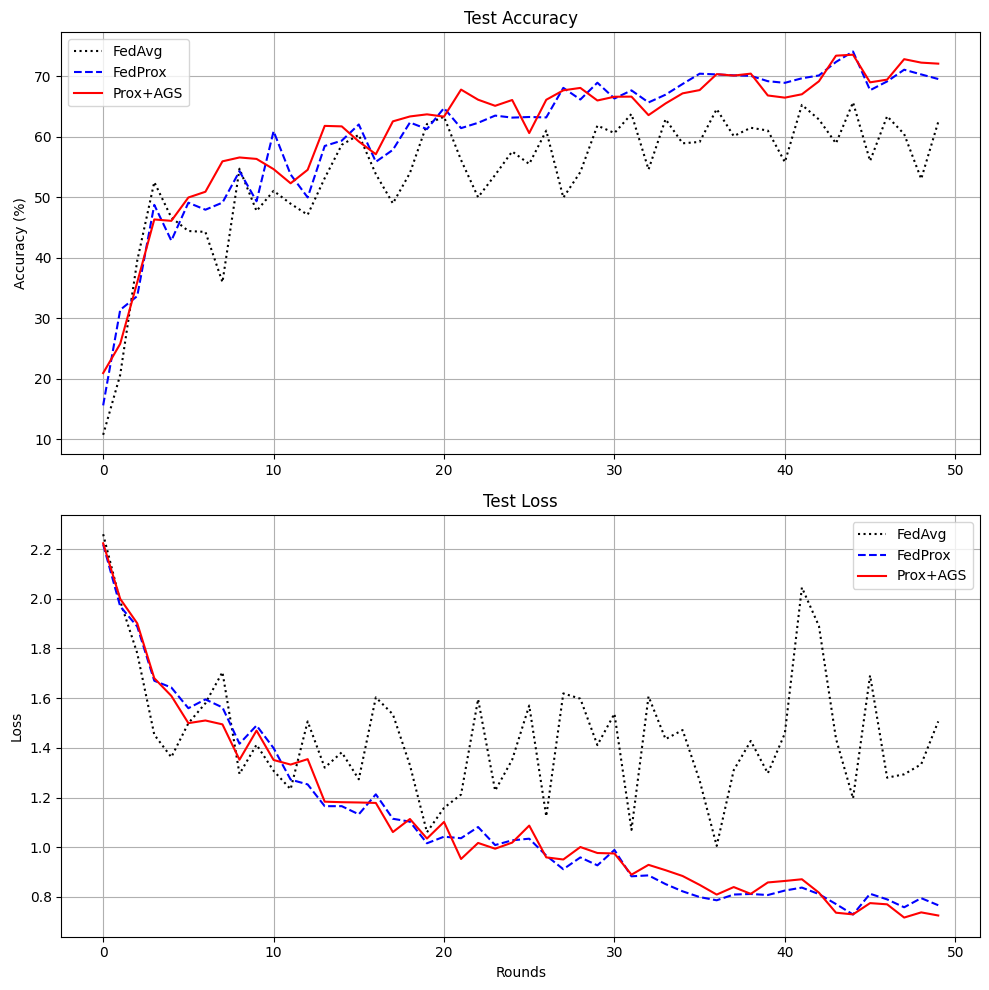

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import copy
import random
import matplotlib.pyplot as plt

# ==============================================================================
# [설정] Code 5 기반 (AGS) + Loss 출력 추가
# ==============================================================================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {DEVICE}")

NUM_CLIENTS = 20
NUM_SELECTED = 10
NUM_ROUNDS = 50
BATCH_SIZE = 10
LR = 0.1
MU = 1.0
AGS_RATIO = 0.4

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

seed_everything(42)

# ==============================================================================
# 1. Dataset
# ==============================================================================
def get_fashion_mnist_noniid():
    print(">>> Fashion-MNIST 로드 및 Non-IID 분할...")
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    train_ds = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
    test_ds = datasets.FashionMNIST('./data', train=False, download=True, transform=transform)

    data_by_class = {i: [] for i in range(10)}
    for idx, target in enumerate(train_ds.targets):
        data_by_class[target.item()].append(idx)

    shards = []
    for cls in range(10):
        indices = data_by_class[cls]
        shard_len = len(indices) // 4
        for i in range(4):
            shards.append(indices[i*shard_len : (i+1)*shard_len])

    random_state = np.random.RandomState(42)
    random_state.shuffle(shards)

    client_indices = []
    for i in range(NUM_CLIENTS):
        client_indices.append(shards[2*i] + shards[2*i+1])

    return train_ds, test_ds, client_indices

# ==============================================================================
# 2. Model
# ==============================================================================
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 100)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# ==============================================================================
# 3. Local Training (AGS Logic Included)
# ==============================================================================
class LocalUpdate:
    def __init__(self, dataset, indices, device, client_id):
        self.loader = DataLoader(Subset(dataset, indices), batch_size=BATCH_SIZE, shuffle=True)
        self.device = device
        self.client_id = client_id
        self.criterion = nn.CrossEntropyLoss()
        self.residual = {}

    def train(self, global_model, mu, is_prox, use_ags=False):
        model = copy.deepcopy(global_model).to(self.device)
        model.train()
        optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.5)
        global_params = [p.clone().detach() for p in global_model.parameters()]

        if self.client_id % 3 == 0:
            epochs = 1
        else:
            epochs = 5

        for _ in range(epochs):
            for data, target in self.loader:
                data, target = data.to(self.device), target.to(self.device)
                optimizer.zero_grad()
                output = model(data)
                loss = self.criterion(output, target)

                if is_prox and mu > 0:
                    prox_term = 0.0
                    for w, w_t in zip(model.parameters(), global_params):
                        prox_term += (w - w_t.to(self.device)).norm(2)**2
                    loss += (mu / 2) * prox_term

                loss.backward()
                optimizer.step()

        final_state = model.state_dict()

        if use_ags:
            return self.apply_ags(final_state, global_model.state_dict())
        else:
            return final_state, len(self.loader.dataset)

    def apply_ags(self, local_state, global_state):
        sparse_update = copy.deepcopy(local_state)
        for key in sparse_update.keys():
            delta = local_state[key] - global_state[key].to(self.device)
            if key not in self.residual:
                self.residual[key] = torch.zeros_like(delta)
            delta += self.residual[key]

            flattened = torch.abs(delta).flatten()
            k = int(len(flattened) * AGS_RATIO)
            if k > 0:
                threshold_val, _ = torch.topk(flattened, k)
                threshold = threshold_val[-1]
                mask = torch.abs(delta) >= threshold
            else:
                mask = torch.zeros_like(delta, dtype=torch.bool)

            sparse_delta = delta * mask.float()
            self.residual[key] = delta - sparse_delta
            sparse_update[key] = global_state[key].to(self.device) + sparse_delta

        return sparse_update, len(self.loader.dataset)

# ==============================================================================
# 4. Server Logic (Loss 추가됨)
# ==============================================================================
def average_weights(w_list, counts):
    w_avg = copy.deepcopy(w_list[0])
    total_count = sum(counts)
    for k in w_avg.keys():
        w_avg[k] = w_avg[k] * counts[0]
        for i in range(1, len(w_list)):
            w_avg[k] += w_list[i][k] * counts[i]
        w_avg[k] = w_avg[k] / total_count
    return w_avg

def evaluate(model, test_loader, device):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    correct = 0; total = 0
    test_loss = 0.0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    return 100 * correct / total, test_loss / len(test_loader)

# ==============================================================================
# 5. Experiment
# ==============================================================================
def run_experiment():
    train_ds, test_ds, user_groups = get_fashion_mnist_noniid()
    test_loader = DataLoader(test_ds, batch_size=100, shuffle=False)

    model_avg = SimpleNN().to(DEVICE)
    model_prox = SimpleNN().to(DEVICE)
    model_ags = SimpleNN().to(DEVICE)
    model_prox.load_state_dict(model_avg.state_dict())
    model_ags.load_state_dict(model_avg.state_dict())

    clients_avg = [LocalUpdate(train_ds, user_groups[i], DEVICE, i) for i in range(NUM_CLIENTS)]
    clients_prox = [LocalUpdate(train_ds, user_groups[i], DEVICE, i) for i in range(NUM_CLIENTS)]
    clients_ags = [LocalUpdate(train_ds, user_groups[i], DEVICE, i) for i in range(NUM_CLIENTS)]

    h_acc_avg, h_loss_avg = [], []
    h_acc_prox, h_loss_prox = [], []
    h_acc_ags, h_loss_ags = [], []

    print(f"\n[Simulation] Code 5 (3-Way) + Loss Tracking")
    print(f"{'Round':^5}|{'Avg Acc':^8}|{'Prox Acc':^8}|{'AGS Acc':^8}|{'Avg Loss':^9}|{'Prox Loss':^9}|{'AGS Loss':^9}")
    print("="*75)

    for round_idx in range(NUM_ROUNDS):
        idxs_users = np.random.choice(range(NUM_CLIENTS), NUM_SELECTED, replace=False)

        # 1. FedAvg
        w_list, s_list = [], []
        for idx in idxs_users:
            w, s = clients_avg[idx].train(model_avg, 0.0, False, use_ags=False)
            w_list.append(w); s_list.append(s)
        model_avg.load_state_dict(average_weights(w_list, s_list))

        # 2. FedProx
        w_list, s_list = [], []
        for idx in idxs_users:
            w, s = clients_prox[idx].train(model_prox, MU, True, use_ags=False)
            w_list.append(w); s_list.append(s)
        model_prox.load_state_dict(average_weights(w_list, s_list))

        # 3. Prox + AGS
        w_list, s_list = [], []
        for idx in idxs_users:
            w, s = clients_ags[idx].train(model_ags, MU, True, use_ags=True)
            w_list.append(w); s_list.append(s)
        model_ags.load_state_dict(average_weights(w_list, s_list))

        # Evaluation
        acc_avg, loss_avg = evaluate(model_avg, test_loader, DEVICE)
        acc_prox, loss_prox = evaluate(model_prox, test_loader, DEVICE)
        acc_ags, loss_ags = evaluate(model_ags, test_loader, DEVICE)

        h_acc_avg.append(acc_avg); h_loss_avg.append(loss_avg)
        h_acc_prox.append(acc_prox); h_loss_prox.append(loss_prox)
        h_acc_ags.append(acc_ags); h_loss_ags.append(loss_ags)

        print(f"{round_idx+1:^5}|{acc_avg:^8.2f}|{acc_prox:^8.2f}|{acc_ags:^8.2f}|{loss_avg:^9.4f}|{loss_prox:^9.4f}|{loss_ags:^9.4f}")

    # Plotting
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

    # Accuracy
    ax1.plot(h_acc_avg, 'k:', label='FedAvg')
    ax1.plot(h_acc_prox, 'b--', label='FedProx')
    ax1.plot(h_acc_ags, 'r-', label='Prox+AGS')
    ax1.set_title("Test Accuracy")
    ax1.set_ylabel("Accuracy (%)")
    ax1.legend(); ax1.grid()

    # Loss
    ax2.plot(h_loss_avg, 'k:', label='FedAvg')
    ax2.plot(h_loss_prox, 'b--', label='FedProx')
    ax2.plot(h_loss_ags, 'r-', label='Prox+AGS')
    ax2.set_title("Test Loss")
    ax2.set_xlabel("Rounds")
    ax2.set_ylabel("Loss")
    ax2.legend(); ax2.grid()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    run_experiment()